# Data pre-processing

## TODOs longterm:
* include the different product types which are relevant for mode shift

In [1]:
# case setting 
case = 1 # 1, 2, 3, 4

In [2]:
Y = 21
prey_y = 10
G = Y + prey_y
y_init = 2020
g_init = y_init - prey_y
Y_end = y_init + Y
print(y_init, Y, prey_y, Y_end, G, g_init)



2020 21 10 2041 31 2010


In [3]:
import sys
sys.path.append('.')
from preprocessing_fix_for_nuts3 import (
    create_nuts3_paths_from_traffic,
    create_simplified_spatial_flexibility
)

Rules: network_cost, elec_price
Case 1: const, const
Case 2: diff, const
Case 3: const, diff
Case 4: diff, diff

In [4]:
electricity_prices_variable = False
network_connection_variable = False

In [5]:
import geopandas as gpd
import pandas as pd
# resolution = "original"
resolution = "reduced"

if resolution == "original":
    folder = "data/Trucktraffic/"
else:
    folder = "data/Trucktraffic_NUTS3/"

In [6]:
# ============================================================================
# NUTS-3 PREPROCESSING FIX
# ============================================================================
import sys
sys.path.append('.')
from preprocessing_fix_for_nuts3 import (
    create_nuts3_paths_from_traffic,
    create_simplified_spatial_flexibility
)
print("Loaded NUTS-3 preprocessing functions")

Loaded NUTS-3 preprocessing functions


In [7]:
# Nuts regions 
nuts_regions = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


## Step 1: Definition of regions within SM corridor

In [8]:
# loading the dataset 
nuts_3_to_nodes = pd.read_csv(folder + "02_NUTS-3-Regions.csv")

# filter rule 
nuts_to_filter_for = { "NUTS_0": ["DE", "DK"],
                      
                        "NUTS_1": ["SE1", "SE2", "AT3", "ITC", "ITH", "ITI", "ITF"],
                      "NUTS_2": ["SE11", "SE12", "SE21", "SE22", "NO08", "NO09","NO02", "NO0A"],}

## Step 2: Filtering route set for relevant routes

In [9]:
for level, nuts_list in nuts_to_filter_for.items():
    missing = [nuts for nuts in nuts_list if nuts not in nuts_regions['NUTS_ID'].values]
    print(f"Missing {level} codes in NUTS_ID: {missing}")

Missing NUTS_0 codes in NUTS_ID: []
Missing NUTS_1 codes in NUTS_ID: []
Missing NUTS_2 codes in NUTS_ID: []


In [10]:
from shapely import wkt

# Filter nuts_regions for the selected NUTS_2 codes
filtered_nodes_by_level = {}

# Convert nuts_3_to_nodes to a GeoDataFrame if not already done
if 'nuts_3_to_nodes_gdf' not in locals():
    nuts_3_to_nodes_gdf = gpd.GeoDataFrame(
        nuts_3_to_nodes,
        geometry=nuts_3_to_nodes['Geometric_center'].apply(wkt.loads),
        crs=nuts_regions.crs
    )

for level, nuts_list in nuts_to_filter_for.items():
    selected_polygons = nuts_regions[nuts_regions['NUTS_ID'].isin(nuts_list)]
    filtered_nodes = gpd.sjoin(nuts_3_to_nodes_gdf, selected_polygons, predicate='within')
    filtered_nodes_by_level[level] = filtered_nodes

# Show the filtered nodes for each level
# for level, df in filtered_nodes_by_level.items():
#     print(f"Filtered nodes for {level}:")
#     print(df)

# Concatenate all filtered nodes into a single GeoDataFrame
all_filtered_nodes = gpd.GeoDataFrame(
    pd.concat(filtered_nodes_by_level.values(), ignore_index=True),
    crs=nuts_3_to_nodes_gdf.crs
)
print(len(all_filtered_nodes))

585


In [11]:
network_nodes = pd.read_csv(folder + "03_network-nodes.csv")
network_edges = pd.read_csv(folder + "04_network-edges.csv")


# Filter network_nodes for ETISplus_Zone_ID values present in all_filtered_nodes
filtered_network_nodes = network_nodes[network_nodes['ETISplus_Zone_ID'].isin(all_filtered_nodes['ETISPlus_Zone_ID'])]

print(filtered_network_nodes.head())
print(len(filtered_network_nodes))

filtered_node_ids = set(filtered_network_nodes['Network_Node_ID'])
filtered_network_edges = network_edges[
    network_edges['Network_Node_A_ID'].isin(filtered_node_ids) &
    network_edges['Network_Node_B_ID'].isin(filtered_node_ids)
]

print(filtered_network_edges.head())
print(len(filtered_network_edges))


     Network_Node_ID  Network_Node_X  Network_Node_Y  ETISplus_Zone_ID Country
405           108492         6.09583         50.7598         107100201      DE
409           196402         6.17193         51.0442         107100209      DE
411           121718         6.21743         59.0615         125000403      NO
414           111714         6.23823         50.7222         107100205      DE
415           196550         6.23987         51.6305         107100111      DE
573
    Network_Edge_ID  Manually_Added  Distance  Network_Node_A_ID  \
33               33               0    11.077             202005   
34               34               0     2.604             202005   
36               36               0     3.161             197964   
37               37               0     6.546             197964   
39               39               0     5.494             100129   

    Network_Node_B_ID  Traffic_flow_trucks_2019  Traffic_flow_trucks_2030  
33             197964                

In [12]:
truck_traffic = pd.read_csv(folder + "01_Trucktrafficflow.csv")

if resolution == "reduced":
    # For NUTS-3, skip edge filtering (different edge ID space)
    filtered_truck_traffic = truck_traffic.copy()
    print(f"NUTS-3 mode: Loaded {len(filtered_truck_traffic):,} routes (no edge filtering)")
else:
    # For original data, filter by edges
    # Convert the string representation of lists to actual lists of integers
    truck_traffic['Edge_path_E_road'] = truck_traffic['Edge_path_E_road'].apply(
        lambda x: [int(i) for i in x.strip('[]').split(',') if i.strip().isdigit()]
    )

    # Get the set of filtered Network_Edge_IDs
    filtered_edge_ids = set(filtered_network_edges['Network_Edge_ID'])

    # Keep only rows where all edges in Edge_path_E_road are in filtered_edge_ids
    def all_edges_in_filtered(edge_list):
        return all(e in filtered_edge_ids for e in edge_list)

    filtered_truck_traffic = truck_traffic[
        truck_traffic['Edge_path_E_road'].apply(all_edges_in_filtered)
    ].copy()
    print(f"Original mode: Filtered to {len(filtered_truck_traffic):,} routes")

NUTS-3 mode: Loaded 1,514,573 routes (no edge filtering)


In [13]:
print(len(filtered_truck_traffic))
print(filtered_truck_traffic.head())

1514573
   ID_origin_region Name_origin_region  ID_destination_region  \
0         101010101   Mittelburgenland              101010201   
1         101010101   Mittelburgenland              101010203   
2         101010101   Mittelburgenland              101010204   
3         101010101   Mittelburgenland              101010205   
4         101010101   Mittelburgenland              101010206   

   Name_destination_region  Traffic_flow_trucks_2010  \
0  Mostviertel-Eisenwurzen                    493.75   
1             Sankt Polten                    556.25   
2              Waldviertel                    472.50   
3              Weinviertel                    248.75   
4   Wiener Umland/Nordteil                    598.75   

   Traffic_flow_trucks_2019  Traffic_flow_trucks_2030  Traffic_flow_tons_2010  \
0                    511.25                    533.75                  6715.0   
1                    576.25                    601.25                  7565.0   
2                    

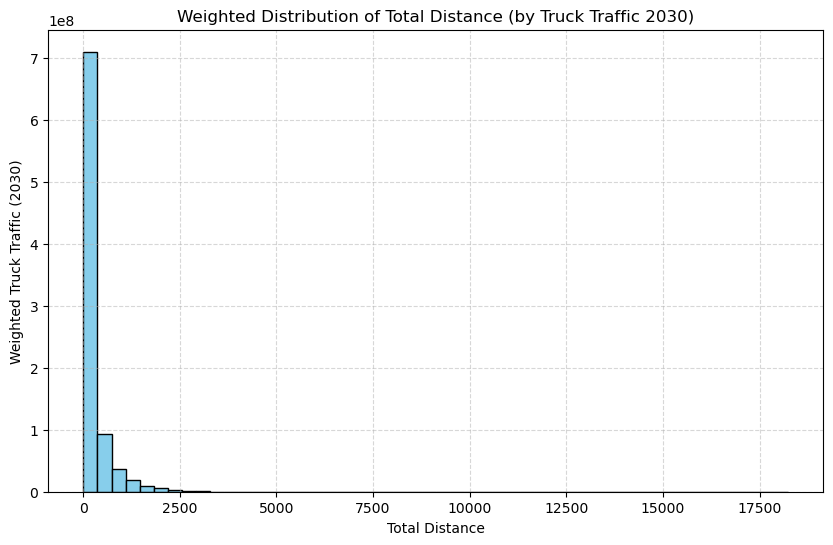

Average: 1559.69, Min: 8.00, Max: 18234.00


In [14]:
import matplotlib.pyplot as plt
filtered_truck_traffic['Total_distance'] = (
    filtered_truck_traffic['Distance_from_origin_region_to_E_road'] +
    filtered_truck_traffic['Distance_within_E_road'] +
    filtered_truck_traffic['Distance_from_E_road_to_destination_region']
)
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic['Total_distance'],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('Total Distance')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title('Weighted Distribution of Total Distance (by Truck Traffic 2030)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
avg = filtered_truck_traffic['Total_distance'].mean()
min_val = filtered_truck_traffic['Total_distance'].min()
max_val = filtered_truck_traffic['Total_distance'].max()
print(f"Average: {avg:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

## Step 3: Mapping to relevant NUTS-2 regions

substeps:
3.1 getting relevant NUTS-2 regions -- check
3.2 cutting routes to relevant regions 
3.3 mapping from NUTS-3 to NUTS-2 

### Step 3.2.: getting relevant NUTS-2 regions

In [15]:
print(nuts_regions.keys())

Index(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry'],
      dtype='object')


In [16]:
# Collect all relevant NUTS_IDs from nuts_to_filter_for
relevant_codes = []
for codes in nuts_to_filter_for.values():
    relevant_codes.extend(codes)

# Filter nuts_regions for LEVL_CODE == 2 and NUTS_ID containing any relevant code
mask = (nuts_regions['LEVL_CODE'] == 3) & (
    nuts_regions['NUTS_ID'].apply(lambda x: any(code in x for code in relevant_codes))
)
relevant_nuts_regions = nuts_regions[mask]
print(relevant_nuts_regions[['NUTS_ID', 'NUTS_NAME']])

     NUTS_ID                    NUTS_NAME
322    DE254   Nürnberg, Kreisfreie Stadt
323    DE255  Schwabach, Kreisfreie Stadt
324    DE256           Ansbach, Landkreis
325    DE257           Erlangen-Höchstadt
402    DE258             Fürth, Landkreis
...      ...                          ...
1668   SE212               Kronobergs län
1669   SE213                   Kalmar län
1670   SE214                 Gotlands län
1671   SE221                 Blekinge län
1672   SE224                    Skåne län

[542 rows x 2 columns]


In [17]:
if resolution != "reduced":
    # Original high-resolution workflow only
    # Create a mapping from Network_Edge_ID to Distance for filtered_network_edges
    edge_distance_map = dict(zip(filtered_network_edges['Network_Edge_ID'], filtered_network_edges['Distance']))

    def reduce_route_and_distance(edge_list):
        # Keep only edges that are in filtered_edge_ids
        reduced_route = [e for e in edge_list if e in filtered_edge_ids]
        # Calculate the total distance for the reduced route
        reduced_distance = sum(edge_distance_map.get(e, 0) for e in reduced_route)
        return pd.Series({'Reduced_Edge_path': reduced_route, 'Reduced_Distance': reduced_distance})

    # Apply the function to filtered_truck_traffic
    filtered_truck_traffic[['Reduced_Edge_path', 'Reduced_Distance']] = filtered_truck_traffic['Edge_path_E_road'].apply(reduce_route_and_distance)
    print(f"Calculated reduced routes for {len(filtered_truck_traffic)} records")
else:
    # NUTS-3 workflow - skip this step
    print("NUTS-3 mode: Skipping edge path reduction (not applicable to aggregated data)")


NUTS-3 mode: Skipping edge path reduction (not applicable to aggregated data)


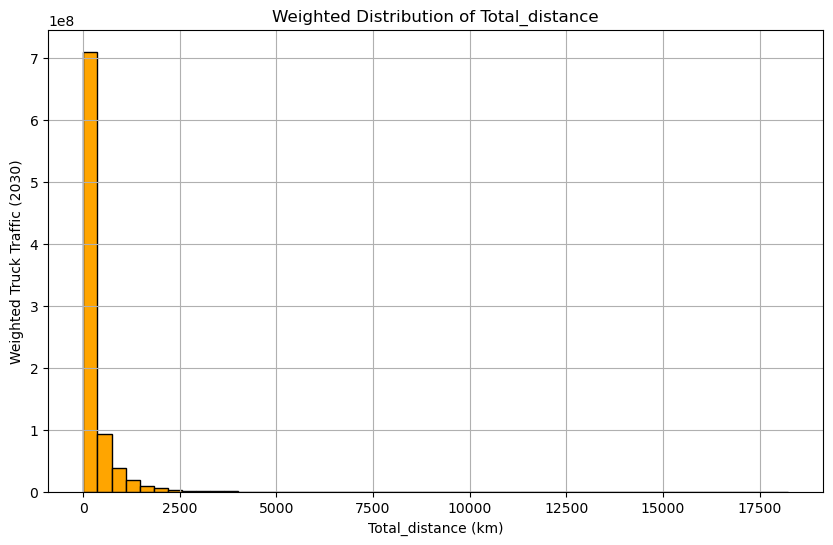

In [18]:
# Distance distribution histogram
if resolution != "reduced":
    # Original workflow - use Reduced_Distance
    distance_col = 'Reduced_Distance'
else:
    # NUTS-3 workflow - use Total_distance
    distance_col = 'Total_distance'

plt.figure(figsize=(10, 6))
plt.hist(
    filtered_truck_traffic[distance_col],
    bins=50,
    weights=filtered_truck_traffic['Traffic_flow_trucks_2030'],
    color='orange',
    edgecolor='black'
)
plt.xlabel(f'{distance_col} (km)')
plt.ylabel('Weighted Truck Traffic (2030)')
plt.title(f'Weighted Distribution of {distance_col}')
plt.grid(True)
plt.show()


__What do I need as input data?__

* TechVehicle (check)
* VehicleType (check)
* Modes(check)
* Technology (check)
* Fuel (check)
* Product types (check)
* Regiontype (check)
* Speed (check)
* InititalModeInfr (check)
* InititalFuelingInfr (check)
* Odpair (check)
* Path (check)
* GeographicElement (check)
* Model Params
* InititalVehicleStock (check) 
* FinancialStatus (only one indicating frequency of new purchases) (check)
* MaximumFuelingCapacityByType 
* FuelingInfrTypes (check)
* MaximumFuelingCapacityByTypeByYear

### Preparing demand side parameters

Main assumptions:
* electrification of interregional road freight is currently 0 
* current assumption: constant transport demand values for road freight
* long-haul is: > 350km

In [19]:
if resolution == "reduced":
    # For NUTS-3, use Total_distance (Reduced_Distance doesn't work with aggregated edges)
    long_haul_truck_traffic = filtered_truck_traffic[filtered_truck_traffic['Total_distance'] >= 0].copy()
else:
    # For original, use Reduced_Distance
    long_haul_truck_traffic = filtered_truck_traffic[filtered_truck_traffic['Reduced_Distance'] >= 0].copy()

print(f"Long-haul routes: {len(long_haul_truck_traffic)}")

Long-haul routes: 1514573


In [20]:
import numpy as np

carbon_price = {2018: 15.06, 2020: 30, 2025: 51.5871, 2030: 76.4254, 2035: 113.223, 2040: 167.737, 2045:248.5, 2050: 355}


def interpolate_carbon_price(year, carbon_price_dict):
    """
    Interpolates the carbon price for a given year based on a dictionary of defined values.

    :param year: The year for which to interpolate the carbon price.
    :param carbon_price_dict: A dictionary with years as keys and carbon prices as values.
    :return: The interpolated carbon price for the given year.
    """
    years = np.array(list(carbon_price_dict.keys()))
    prices = np.array(list(carbon_price_dict.values()))
    
    if year < years.min():
        # Extrapolate for years before the minimum defined year
        slope = (prices[1] - prices[0]) / (years[1] - years[0])
        return prices[0] + slope * (year - years[0])
    elif year > years.max():
        # Extrapolate for years after the maximum defined year
        slope = (prices[-1] - prices[-2]) / (years[-1] - years[-2])
        return prices[-1] + slope * (year - years[-1])
    else:
        # Interpolate for years within the defined range
        return np.interp(year, years, prices)

# Example usage
print(interpolate_carbon_price(2023, carbon_price))
carbon_price_dict = {year: interpolate_carbon_price(year, carbon_price) for year in range(2020, 2062)}

42.95226


In [21]:
# creating geographic_elements - ONE PER NETWORK NODE (optimized)
geographic_elements = []

# Create node ID mapping (Network_Node_ID -> sequential ID)
node_id_mapping = {}

# Pre-calculate carbon prices once
carbon_prices = [float(carbon_price_dict[year+y_init]) for year in range(Y)]
id = 0
for index, row in filtered_network_nodes.iterrows():
    network_node_id = int(row['Network_Node_ID'])
    node_id_mapping[network_node_id] = id  # Map Network_Node_ID -> sequential ID
    
    geographic_elements.append({
        "id": id,  # Use sequential ID
        "type": "node",
        "name": f"node_{network_node_id}",
        "nuts3_region": row['ETISplus_Zone_ID'],
        "country": row['Country'],
        "carbon_price": carbon_prices,  # Reuse same list
        "from": 999999,
        "to": 999999,
        "length": 0.0,
        "coordinate_lat": row['Network_Node_Y'],
        "coordinate_long": row['Network_Node_X'],
    })
    id += 1

# Create mapping dictionaries for fast lookups (still using Network_Node_ID for compatibility)
node_id_to_geo = {int(row['Network_Node_ID']): {
    'id': int(row['Network_Node_ID']),
    'country': row['Country'],
    'nuts3': row['ETISplus_Zone_ID'],
    'coords': (row['Network_Node_X'], row['Network_Node_Y'])
} for _, row in filtered_network_nodes.iterrows()}

print(f"Number of geographic elements: {len(geographic_elements)}")
print(f"Node ID mapping created: {len(node_id_mapping)} entries")
print(f"Created lookup dictionary with {len(node_id_to_geo)} entries")


Number of geographic elements: 573
Node ID mapping created: 555 entries
Created lookup dictionary with 555 entries


In [23]:
# ============================================================================# CREATE OD-PAIRS AND PATHS FOR NUTS-3 DATA# ============================================================================
print("="*80)
print("CREATING NUTS-3 OD-PAIRS AND PATHS")
print("="*80)
# ADJUSTABLE PARAMETERS
MAX_ODPAIRS = 1000  # Change this to None for full dataset
# Auto-detect traffic variable
traffic_var = None
for var_name in ['long_haul_truck_traffic', 'filtered_truck_traffic', 'truck_traffic']:
    if var_name in dir():
        traffic_var = eval(var_name)
        print(f"Using traffic data: {var_name} ({len(traffic_var):,} rows)")
        break
# Auto-detect nodes variable
nodes_var = None
for var_name in ['filtered_network_nodes', 'network_nodes']:
    if var_name in dir():
        nodes_var = eval(var_name)
        print(f"Using network nodes: {var_name} ({len(nodes_var):,} nodes)")
        break
# Auto-detect edges variable
edges_var = None
for var_name in ['filtered_network_edges', 'network_edges']:
    if var_name in dir():
        edges_var = eval(var_name)
        print(f"Using network edges: {var_name} ({len(edges_var):,} edges)")
        break
# Filter traffic to only include OD-pairs within filtered network
if nodes_var is not None and traffic_var is not None:
    filtered_region_ids = set(nodes_var['ETISplus_Zone_ID'].unique())
    print(f"Filtered network regions: {len(filtered_region_ids)}")
    
    # Count before filtering
    rows_before = len(traffic_var)
    
    # Filter: keep only traffic where BOTH origin AND destination are in filtered regions
    traffic_var = traffic_var[
        traffic_var['ID_origin_region'].isin(filtered_region_ids) &
        traffic_var['ID_destination_region'].isin(filtered_region_ids)
    ].copy()
    
    rows_after = len(traffic_var)
    print(f"Traffic rows before filtering: {rows_before:,}")
    print(f"Traffic rows after filtering: {rows_after:,}")
    print(f"Rows removed: {rows_before - rows_after:,}")

# Create OD-pairs and paths (node_id_mapping created in previous cell)
odpair_list, path_list, initial_vehicle_stock = create_nuts3_paths_from_traffic(
      truck_traffic=traffic_var,
      network_nodes=nodes_var,
      network_edges=edges_var,
      node_id_mapping=node_id_mapping,
      max_odpairs=MAX_ODPAIRS,
      y_init=y_init,
      prey_y=prey_y
  )


CREATING NUTS-3 OD-PAIRS AND PATHS
Using traffic data: long_haul_truck_traffic (1,514,573 rows)
Using network nodes: filtered_network_nodes (573 nodes)
Using network edges: filtered_network_edges (772 edges)
Filtered network regions: 573
Traffic rows before filtering: 1,514,573
Traffic rows after filtering: 244,719
Rows removed: 1,269,854
CREATING NUTS-3 PATHS AND OD-PAIRS
Valid traffic rows: 224,425
Node mapping: 573 NUTS-3 regions
Edge lookup: 669 edges

Grouping traffic by origin-destination...
Unique OD-pairs: 224,425
Limited to top 1000 OD-pairs by traffic volume

Creating OD-pairs and paths...

DEBUG: Sample traffic origin regions: [125000102, 125000101, 108000402, 108000302, 129020302]
DEBUG: Sample node ETISplus_Zone_IDs: [107100201, 107100209, 125000403, 107100205, 107100111]
  Created 100 OD-pairs...
  Created 200 OD-pairs...
  Created 300 OD-pairs...
  Created 400 OD-pairs...
  Created 500 OD-pairs...
  Created 600 OD-pairs...
  Created 700 OD-pairs...
  Created 800 OD-pairs

In [ ]:
 # Filter for international routes only
# Map ETISplus Zone IDs to countries using filtered_network_nodes
zone_to_country = dict(zip(filtered_network_nodes['ETISplus_Zone_ID'], filtered_network_nodes['Country']))

# Add origin and destination countries
long_haul_truck_traffic['origin_country'] = long_haul_truck_traffic['ID_origin_region'].map(zone_to_country)
long_haul_truck_traffic['destination_country'] = long_haul_truck_traffic['ID_destination_region'].map(zone_to_country)

# Filter for international routes (origin country != destination country)
international_routes = long_haul_truck_traffic[
    long_haul_truck_traffic['origin_country'] != long_haul_truck_traffic['destination_country']
].copy()

print(f"Long-haul routes (>= 350 km): {len(long_haul_truck_traffic)}")
print(f"International long-haul routes: {len(international_routes)}")
print(f"Domestic long-haul routes filtered out: {len(long_haul_truck_traffic) - len(international_routes)}")

# Replace long_haul_truck_traffic with international routes
long_haul_truck_traffic = international_routes

Long-haul routes (>= 350 km): 1514573
International long-haul routes: 1387576
Domestic long-haul routes filtered out: 126997


In [25]:
# This function is no longer needed - network nodes ARE geographic elements now!
# Keeping for backwards compatibility but it just returns the node IDs

def map_nodes_to_geo_ids(network_node_ids):
    """
    Map network node IDs to GeographicElement IDs.
    Since we now use network nodes as geo elements, this is a direct mapping.
    """
    return network_node_ids  # Direct mapping!

print("Network nodes are now geographic elements - no mapping needed!")

Network nodes are now geographic elements - no mapping needed!


In [26]:
def get_nodes_along_path(edge_path, edge_df):
    """
    Optimized: Returns a list of node IDs traversed along a connected path of edges.
    """
    if not edge_path:
        return []

    # Pre-filter relevant edges and build lookup dict
    path_edges_df = edge_df[edge_df['Network_Edge_ID'].isin(edge_path)]
    edge_map = {
        int(row['Network_Edge_ID']): (int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID']))
        for _, row in path_edges_df.iterrows()
    }

    if not edge_path or edge_path[0] not in edge_map:
        return []

    # Build path starting from both ends and pick the best
    first_edge = edge_path[0]
    node_a, node_b = edge_map[first_edge]
    
    nodes_a = build_path_from_node(node_a, edge_path, edge_map)
    nodes_b = build_path_from_node(node_b, edge_path, edge_map)
    
    return nodes_a if len(nodes_a) >= len(nodes_b) else nodes_b

def build_path_from_node(start_node, edge_path, edge_map):
    """Optimized: Build connected path from start node"""
    nodes = [start_node]
    current = start_node
    used_edges = set()
    
    for edge_id in edge_path:
        if edge_id not in edge_map or edge_id in used_edges:
            continue
        
        a, b = edge_map[edge_id]
        
        if current == a:
            nodes.append(b)
            current = b
            used_edges.add(edge_id)
        elif current == b:
            nodes.append(a)
            current = a
            used_edges.add(edge_id)
        # If edge doesn't connect, skip it (don't break - might connect later)
    
    return nodes

def validate_connected_sequence(nodes, edge_df):
    """
    Validates that all consecutive node pairs in the sequence are actually connected by edges.
    Returns only the longest connected subsequence.
    """
    if len(nodes) < 2:
        return nodes
    
    # Build edge lookup for validation
    edge_set = set()
    for _, row in edge_df.iterrows():
        a, b = int(row['Network_Node_A_ID']), int(row['Network_Node_B_ID'])
        edge_set.add((a, b))
        edge_set.add((b, a))
    
    # Find longest connected subsequence
    connected_sequences = []
    current_seq = [nodes[0]]
    
    for i in range(len(nodes) - 1):
        node_from = nodes[i]
        node_to = nodes[i + 1]
        
        if (node_from, node_to) in edge_set:
            current_seq.append(node_to)
        else:
            # Disconnected - save current sequence and start new one
            if len(current_seq) > 1:
                connected_sequences.append(current_seq)
            current_seq = [node_to]
    
    # Don't forget last sequence
    if len(current_seq) > 1:
        connected_sequences.append(current_seq)
    
    # Return longest connected sequence
    if connected_sequences:
        return max(connected_sequences, key=len)
    else:
        return nodes[:1]  # Return just first node if no connections found

def sort_nodes_by_path_sequence(nodes_list, origin_id, destination_id, filtered_network_nodes):
    """
    Optimized: Sort nodes by distance from origin to destination using vectorized operations
    """
    if not nodes_list:
        return []
    
    # Get origin/dest coordinates
    origin_row = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == origin_id]
    dest_row = filtered_network_nodes[filtered_network_nodes['ETISplus_Zone_ID'] == destination_id]
    
    if origin_row.empty or dest_row.empty:
        return nodes_list
    
    origin_coord = (origin_row.iloc[0]['Network_Node_X'], origin_row.iloc[0]['Network_Node_Y'])
    dest_coord = (dest_row.iloc[0]['Network_Node_X'], dest_row.iloc[0]['Network_Node_Y'])
    
    # Get coordinates for all nodes in the list
    nodes_df = filtered_network_nodes[filtered_network_nodes['Network_Node_ID'].isin(nodes_list)].copy()
    
    if nodes_df.empty:
        return nodes_list
    
    # Vectorized distance calculation
    from pyproj import Geod
    geod = Geod(ellps="WGS84")
    
    # Calculate sort key for all nodes at once
    def calc_sort_key(row):
        _, _, d_orig = geod.inv(origin_coord[0], origin_coord[1], row['Network_Node_X'], row['Network_Node_Y'])
        _, _, d_dest = geod.inv(dest_coord[0], dest_coord[1], row['Network_Node_X'], row['Network_Node_Y'])
        return d_orig - d_dest
    
    nodes_df['sort_key'] = nodes_df.apply(calc_sort_key, axis=1)
    sorted_df = nodes_df.sort_values('sort_key')
    
    return sorted_df['Network_Node_ID'].tolist()

In [27]:
financial_status_list = [
    {   "id": 0,
        "name": "any",
        "VoT": 0.0,
        "monetary_budget_operational": 0.0,
        "monetary_budget_operational_lb": 0.0,
        "monetary_budget_operational_ub": 0.0,
        "monetary_budget_purchase": 0.0,
        "monetary_budget_purchase_lb": 0.0,
        "monetary_budget_purchase_ub": 0.0,
        "monetary_budget_purchase_time_horizon": 1,
        "average_household_size": 2.4,
     },
]


In [28]:
technologies = ["ICEV", "BEV"]
factors = 1
subsidy = 20000
added_fact = 1
capital_cost_dict = {
    "ICEV": {2020: 105484 * added_fact, 2025: 109159 * added_fact, 2030: 115252 * added_fact, 2040: 115252 * added_fact, 2050: 115252 * added_fact},
    "BEV": {2020: (417255- subsidy)*factors, 2025: (200006- subsidy)*factors, 2030: (145346- subsidy)*factors, 2040: (145346- subsidy)*factors, 2050: (145346- subsidy)*factors},
}
vehicle_tax_ICEV = 561
vehicle_tax_BEV = 5
maintenance_annual_cost_dict = {
    "ICEV": {2020: 20471 + vehicle_tax_ICEV, 2025: 20608 + vehicle_tax_ICEV, 2030: 20608 + vehicle_tax_ICEV, 2040: 20608 + vehicle_tax_ICEV, 2050: 20608 + vehicle_tax_ICEV},
    "BEV": {2020: 14359 + vehicle_tax_BEV, 2050: 14359 + vehicle_tax_BEV},
}

L_to_kWh = 9.7  # kWh per litre of diesel
fuel_economy_dict = {
    "ICEV": {2020: 29.86 * L_to_kWh, 2025: 26.67 * L_to_kWh, 2030: 23.47 * L_to_kWh, 2040: 23.47* L_to_kWh, 2050: 23.47*L_to_kWh},  # in kWh/km
    "BEV": {2020: 1.60, 2025: 1.41, 2030: 1.21, 2040: 1.21, 2050: 1.21},  # in kWh/km
}

maintenance_distance_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}


fuel_costs_dict = {
    "ICEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
    "BEV": {2020: 0, 2035: 0, 2050: 0},  # in kWh/km
}

battery_capacity_dict = {
    "ICEV": {2020: 570 * L_to_kWh, 2035: 570 * L_to_kWh, 2050: 570 * L_to_kWh},  # in kWh/km
    "BEV": {2020: 1187, 2035: 1187, 2050: 1187},  # in kWh/km
}

peak_charging_dict = {
    "ICEV": {2020: 28500, 2035: 28500, 2050: 28500},  # in kWh/km
    "BEV": {2020: 350, 2035: 900, 2050: 1000},  # in kWh/km
}

occ = 13.6/26

W_dict = {
    "ICEV": {2020: 26 * occ, 2035: 26 * occ, 2050: 26 * occ},  # in kWh/km
    "BEV": {2020: 26 * occ * 0.75 , 2035: 26 * occ * 0.75, 2050: 26 * occ * 0.75},  # in kWh/km
}

annual_mileage_dict = {
    "ICEV": {2020: 136750, 2035: 136750, 2050: 136750},  # in km
    "BEV": {2020: 136750, 2035: 136750, 2050: 136750},  # in km
}


In [29]:
def extrapolate_years(known_values: dict, full_years: list) -> dict:
    """
    Linearly interpolate and extrapolate values for given years.
    
    Parameters:
    - known_values: dict of {year: value}
    - full_years: list of all years to cover (can include years outside known)
    
    Returns:
    - dict {year: value} for all years in full_years
    """
    from bisect import bisect_left

    known_years = sorted(known_values.keys())
    result = {}

    for y in sorted(full_years):
        if y in known_values:
            result[y] = known_values[y]
        elif y < known_years[0]:
            # Extrapolate before first known year
            y0, y1 = known_years[0], known_years[1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v0 + slope * (y - y0))
        elif y > known_years[-1]:
            # Extrapolate after last known year
            y0, y1 = known_years[-2], known_years[-1]
            v0, v1 = known_values[y0], known_values[y1]
            slope = (v1 - v0) / (y1 - y0)
            result[y] = float(v1 + slope * (y - y1))
        else:
            # Interpolate between closest known years
            idx = bisect_left(known_years, y)
            y0, y1 = known_years[idx - 1], known_years[idx]
            v0, v1 = known_values[y0], known_values[y1]
            t = (y - y0) / (y1 - y0)
            result[y] = float(v0 + t * (v1 - v0)
)
    return result


In [30]:
def scale_om_costs(original_main_costs, age):
    maintenance_costs = original_main_costs
    for y in range(4, age + 1):
        if y in [4, 5]:
            maintenance_costs = maintenance_costs * 1.05
        else:
            maintenance_costs = maintenance_costs * 1.1

    return maintenance_costs

In [31]:
tech_vehicle_list = []
tech_veh_id = 0

vehs = W_dict.keys()
years = range(y_init, y_init + Y)
generations = range(y_init-G, y_init + Y)
pre_y_init_generations = range(y_init - G, y_init)
print(pre_y_init_generations, y_init)
for tech in vehs:
    generation_dep_om_costs = extrapolate_years(maintenance_annual_cost_dict[tech], range(y_init, y_init + Y))
    generation_dep_om_costs.update({g: generation_dep_om_costs[y_init] for g in pre_y_init_generations})
    yearly_maintenance_costs = [[scale_om_costs(generation_dep_om_costs[g], age) for age in range(1, G+1)] for g in generations] 
    generation_dep_distance_om_costs = extrapolate_years(maintenance_distance_dict[tech], range(y_init, y_init + Y))
    generation_dep_distance_om_costs.update({g: generation_dep_distance_om_costs[y_init] for g in pre_y_init_generations})
    yearly_distance_maintenance_costs = [[scale_om_costs(generation_dep_distance_om_costs[g], age) for age in range(1, G+1)] for g in generations]
    
    extrapolated_fuel_economy = extrapolate_years(fuel_economy_dict[tech], years)
    extrapolated_W = extrapolate_years(W_dict[tech], years)
    extrapolated_tank_capacity = extrapolate_years(battery_capacity_dict[tech], years)
    extrapolated_peak_charging = extrapolate_years(peak_charging_dict[tech], years)
    # FIXED: Match Technology IDs correctly (0=ICEV, 1=BEV)
    if tech == "ICEV":
        t = 0
    else:  # BEV
        t = 1 
    tech_vehicle_list.append({
        "id": tech_veh_id,
        "name": tech,
        "capital_cost": [extrapolate_years(capital_cost_dict[tech], years)[y] for y in years],
        "maintenance_cost_annual": yearly_maintenance_costs,
        "maintenance_cost_distance": yearly_distance_maintenance_costs,
        "spec_cons": G * [extrapolated_fuel_economy[y_init]] + [extrapolated_fuel_economy[y] for y in years],
        "W": G * [extrapolated_W[y_init]] + [extrapolated_W[y] for y in years],
        "Lifetime": [10] * G,
        "AnnualRange": [120000] * G,
        "products": ["freight"],
        "tank_capacity": G * [extrapolated_tank_capacity[y_init]] + [extrapolated_tank_capacity[y] for y in years],
        "vehicle_type": "long-haul truck",
        "technology": t,
        "peak_fueling": G * [extrapolated_peak_charging[y_init]] + [extrapolated_peak_charging[y] for y in years],
        "fueling_time": G * [0.5] + [0.5] * Y,

    })

    tech_veh_id += 1

range(1989, 2020) 2020


In [32]:
# ============================================================================
# CREATE SPATIAL FLEXIBILITY FOR NUTS-3 DATA
# ============================================================================
print("="*80)
print("CREATING SPATIAL FLEXIBILITY")
print("="*80)

# ADJUSTABLE PARAMETER
MAX_FLEXIBILITY = 5  # Adjust this to change spatial flexibility range

spatial_flex_range_list = create_simplified_spatial_flexibility(
    path_list=path_list,
    max_flexibility=MAX_FLEXIBILITY
)

print(f"[OK] Created {len(spatial_flex_range_list)} spatial flexibility entries")

CREATING SPATIAL FLEXIBILITY

Creating spatial flexibility edges...
[OK] Created 2831 spatial flexibility entries
[OK] Created 2831 spatial flexibility entries


In [33]:
print("Creating spatial flexibility edges...")

spatial_flex_range_list = create_simplified_spatial_flexibility(
    path_list=path_list,
    max_flexibility=5
)

print(f"Created {len(spatial_flex_range_list)} spatial flexibility entries")

Creating spatial flexibility edges...

Creating spatial flexibility edges...
[OK] Created 2831 spatial flexibility entries
Created 2831 spatial flexibility entries


In [34]:
# # Create OD-pairs and paths using NUTS-3 simplified approach
# print("="*80)
# print("CREATING OD-PAIRS AND PATHS FOR NUTS-3 DATA")
# print("="*80)

# odpair_list, path_list = create_nuts3_paths_from_traffic(
#     truck_traffic=long_haul_truck_traffic,
#     network_nodes=filtered_network_nodes,
#     network_edges=filtered_network_edges,
#     # max_odpairs=30  # Start with 100 for testing, then remove limit
# )

# print(f"\nCreated {len(odpair_list)} OD-pairs and {len(path_list)} paths")

# # Create initial vehicle stock - empty for NUTS-3
# initial_vehicle_stock = []

In [35]:
print(f"odpair_list length: {len(odpair_list) if 'odpair_list' in dir() else 'NOT DEFINED'}")
print(f"path_list length: {len(path_list) if 'path_list' in dir() else 'NOT DEFINED'}")

odpair_list length: 1000
path_list length: 1000


In [36]:
# from pyproj import Geod
# initial_vehicle_stock = []
# init_veh_stock_id = 0
# odpair_list = []
# path_list = []
# odpair_id = 0
# path_id = 0
# total_rows = len(long_haul_truck_traffic)
# progress_step = max(1, total_rows // 20)
# max_od_id = 10

# disconnected_paths = 0

# for idx, (index, row) in enumerate(long_haul_truck_traffic.iterrows()):
#     if idx % progress_step == 0 or idx == total_rows - 1:
#         print(f"Processing row {idx+1}/{total_rows} ({(idx+1)/total_rows:.1%})")
    
#     F = row["Traffic_flow_trucks_2030"]
#     distance = row["Reduced_Distance"]
#     nb_vehicles = F * ((distance)/(26 * occ * 120000))
#     vehicle_init_ids = []
#     factor = 1/prey_y
    
#     for g in range(prey_y + 1):
#         stock = nb_vehicles * factor
#         initial_vehicle_stock.append({
#             "id": init_veh_stock_id,
#             "techvehicle": 0,
#             "year_of_purchase": y_init - g,
#             "stock": float(round(stock,5)),
#         })
#         vehicle_init_ids.append(init_veh_stock_id)
#         init_veh_stock_id += 1

#         initial_vehicle_stock.append({
#             "id": init_veh_stock_id,
#             "techvehicle": 1,
#             "year_of_purchase": y_init - g,
#             "stock": 0,
#         })
#         vehicle_init_ids.append(init_veh_stock_id)
#         init_veh_stock_id += 1

#     # Get nodes along path
#     nodes_in_route = get_nodes_along_path(row["Reduced_Edge_path"], filtered_network_edges)
    
#     # VALIDATE: Extract only connected nodes
#     validated_nodes = validate_connected_sequence(nodes_in_route, filtered_network_edges)
    
#     if len(validated_nodes) < 2:
#         if odpair_id < 5:  # Show first 5 skipped paths
#             print(f"WARNING: Path {odpair_id} has fewer than 2 connected nodes after validation, skipping")
#         disconnected_paths += 1
#         continue
    
#     # Use validated sequence directly (no sorting)
#     geo_ids = validated_nodes
    
#     # NEW: Calculate cumulative distances from origin and from previous node
#     cumulative_distance_from_origin = [0.0]  # First node is at distance 0
#     distance_from_previous = [0.0]  # First node has no previous node
    
#     for i in range(len(geo_ids) - 1):
#         node_from = geo_ids[i]
#         node_to = geo_ids[i + 1]
        
#         # Look up edge distance
#         edge_key = (node_from, node_to)
#         if edge_key in edge_lookup:
#             edge_dist = edge_lookup[edge_key]
#         else:
#             # Try reverse direction
#             edge_key = (node_to, node_from)
#             edge_dist = edge_lookup.get(edge_key, 0.0)
        
#         # Cumulative distance from origin
#         cumulative_distance_from_origin.append(
#             float(cumulative_distance_from_origin[-1] + edge_dist)
#         )
        
#         # Distance from previous node (this is just the edge distance)
#         distance_from_previous.append(float(edge_dist))
    
#     if odpair_id == 0:
#         print(f"  Total edges in path: {len(row['Reduced_Edge_path'])}")
#         print(f"  Nodes before validation: {len(nodes_in_route)}")
#         print(f"  Nodes after validation: {len(validated_nodes)}")
#         print(f"  First 5 nodes (= geo_ids): {geo_ids[:5]}")
#         print(f"  First 5 cumulative distances: {[round(d, 2) for d in cumulative_distance_from_origin[:5]]}")
#         print(f"  First 5 distances from previous: {[round(d, 2) for d in distance_from_previous[:5]]}")
    
#     origin_geo_id = geo_ids[0] if geo_ids else None
#     destination_geo_id = geo_ids[-1] if geo_ids else None
    
#     odpair_list.append({
#         "id": odpair_id,
#         "from": origin_geo_id,
#         "to": destination_geo_id,
#         "F": [F] * Y,
#         "product": "freight",
#         "vehicle_stock_init": vehicle_init_ids, 
#         "region_type": "highway",
#         "financial_status": "any",
#         "travel_time_budget": 0.0,
#         "purpose": "long-haul",
#         "path_id": path_id,
#     })
    
#     path_list.append({
#         "id": path_id,
#         "name": str(path_id),
#         "length": row["Reduced_Distance"],
#         "from": origin_geo_id,
#         "to": destination_geo_id,
#         "sequence": geo_ids,
#         "cumulative_distance": cumulative_distance_from_origin,  # NEW: Distance from origin
#         "distance_from_previous": distance_from_previous,  # NEW: Distance from previous node
#     })
    
#     odpair_id += 1
#     path_id += 1
#     if odpair_id >= max_od_id:
#         break

# print(f"\nCreated {len(odpair_list)} OD pairs and {len(path_list)} paths")
# print(f"Skipped {disconnected_paths} paths with disconnected edges")

In [37]:
vehicle_type_list = [{
    "id": 0,
    "name": "long-haul truck",
    "mode": 1, 
    "product": "freight",
}]

In [38]:
mode_list = [{
    "id": 1,
    "name": "road",
    "quantify_by_vehs": True,
    "costs_per_ukm": [0] * Y,
    "emission_factor": [699] * Y,
    "infrastructure_expansion_costs": [0.0] * Y,
    "infrastructure_om_costs": [0.1] * Y,
    "waiting_time": [0.0] * Y,
}]


### Geographic variation in connection costs and electricity prices

In [39]:
# ============================================================================
# MANDATORY BREAKS (SIMPLIFIED FOR NUTS-3)
# ============================================================================
print("="*80)
print("HANDLING MANDATORY BREAKS")
print("="*80)

# For NUTS-3 aggregated network, skip mandatory breaks
mandatory_breaks_list = []
print("[OK] Skipping mandatory breaks for NUTS-3 simplified network")

# Uncomment to try calculating:
# try:
#     from mandatory_breaks_calculation import create_mandatory_breaks_list
#     mandatory_breaks_list = create_mandatory_breaks_list(path_list, speed=80)
#     print(f"[OK] Created {len(mandatory_breaks_list)} entries")
# except Exception as e:
#     print(f"[WARNING] Mandatory breaks failed: {e}")
#     mandatory_breaks_list = []

HANDLING MANDATORY BREAKS
[OK] Skipping mandatory breaks for NUTS-3 simplified network


In [40]:
from mandatory_breaks_calculation import create_mandatory_breaks_list
mandatory_breaks_list = create_mandatory_breaks_list(path_list, speed=80)

In [41]:
technology_list = [
    {
        "id": 0,
        "name": "ICEV",
        "fuel": "diesel",
    },
    {
        "id": 1,
        "name": "BEV",
        "fuel": "electricity",
    }
]

In [42]:
speed_list = [
    {
        "id": 0,
        "region_type": "highway",
        "travel_speed": 80,  # see in Shoman et al what their assumption is 
        "vehicle_type": "long-haul truck"
    }
]

region_list = [
    {
        "id": 0,
        "name": "highway",
        "costs_var": [0.0] * Y,
        "costs_fix": [0.0] * Y,
    }
]

In [43]:
initialmodeinfr = []
id = 0

for geo in geographic_elements:
    for m in mode_list:
        initialmodeinfr.append(
            {
                "id": id,
                "mode": m["id"],
                "allocation": geo["id"],
                "installed_ukm": 0,
                "costs_per_ukm": [0.0] * Y,
            }
        )
        id += 1

In [44]:
initialfuelinfr = []

id_count = 0
for geo in geographic_elements:
    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "electricity",
            "allocation": geo["id"],
            "installed_kW": 0,
            "type": "slow_charging_station",
            "by_income_class": False,
            "income_class": "any",
        }
    )
    id_count += 1

    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "electricity",
            "allocation": geo["id"],
            "installed_kW": 0,
            "type": "fast_charging_station",
            "by_income_class": False,
            "income_class": "any",
        }
    )
    id_count += 1

    initialfuelinfr.append(
        {
            "id": id_count,
            "fuel": "diesel",
            "allocation": geo["id"],
            "installed_kW": 900000,
            "type": "conventional_fueling_station",
            "by_income_class": False,
            "income_class": "any",
        }
    )
    id_count += 1

In [45]:
costs_for_megawatt_charging =  ((336 + 460)/2 + (94.5 + 114)/2) + 10 ** (-3) * 900  # in million USD per MW
print(costs_for_megawatt_charging)

hardware_costs = {2025: (336 + 460)/2, 2030: (303 + 437)/2, 2035: (273 + 415)/2, 2040: (245 + 395)/2, 2045: (221 + 375)/2, 2050: (199 + 356)/2}
installation_costs = {2025: (94.5 + 114)/2, 2030: (85.1 + 108)/2, 2035: (76.5 + 103)/2, 2040: (68.9 + 98)/2, 2045: (62 + 93)/2, 2050: (55.8 + 88)/2}
grid_connection = 900
mega_watt_ch = 1000
total_install_kW_costs = {year: hardware_costs[year] + installation_costs[year] + grid_connection/mega_watt_ch for year in hardware_costs.keys()}
costs_dev_mega = extrapolate_years(total_install_kW_costs, range(y_init, y_init + Y))
print(costs_dev_mega)

503.15
{2020: 538.8499999999999, 2021: 531.7099999999999, 2022: 524.5699999999999, 2023: 517.43, 2024: 510.28999999999996, 2025: 503.15, 2026: 496.01, 2027: 488.87, 2028: 481.72999999999996, 2029: 474.59, 2030: 467.45, 2031: 460.89, 2032: 454.33, 2033: 447.77, 2034: 441.21, 2035: 434.65, 2036: 428.59, 2037: 422.53, 2038: 416.46999999999997, 2039: 410.40999999999997, 2040: 404.34999999999997}


In [ ]:
charging_types_list = []

# TODO: differentiate between fast and overnight charging for trucks based on Shoman et al. (2023)
charging_types_list.append({
    "id": 1,
    "fuel": "electricity",
    "fueling_type": "slow_charging_station",
    "fueling_power": [1000] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)] * Y,  # TODO: improving by year
    "cost_per_kWh_network": [0.0] * Y,  # TODO: improving by year
    "om_costs": [0.03 * float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)],  # 2% of investment cost per year
})

charging_types_list.append({
    "id": 2,
    "fuel": "electricity",
    "fueling_type": "fast_charging_station",
    "fueling_power": [100] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)],  # Plözl, 2025
    "cost_per_kWh_network": [0.0] * Y,  # TODO: improving by year
    "om_costs": [0.03 * float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)],  # 2% of investment cost per year

})

charging_types_list.append({
    "id": 0,
    "fuel": "diesel",
    "fueling_type": "conventional_fueling_station",
    "fueling_power": [10000] * Y,  # kW    # TODO: improving by year 
    "additional_fueling_time": False,
    "max_occupancy_rate_veh_per_year": 60,  # Use Shoman et al. (2023) assumption
    "by_route": False,
    "track_detour_time": False,
    "gamma": [0.3] * Y,
    "cost_per_kW": [0.0] * Y,  # TODO: improving by year
    "cost_per_kWh_network": [0.0] * Y,  # TODO
    "om_costs": [0.01 * float(costs_dev_mega[year]) for year in range(y_init, y_init + Y)]  # 2% of investment cost per year
})

### Including the travel time constraints

In [47]:
# TODO: connection costs for charging stations

conn_costs = pd.read_excel("data/electricity data/41467_2022_32835_MOESM4_ESM.xlsx", sheet_name="Main results", header=1)

In [48]:
print(conn_costs.keys())
print("Unique values in 'Country':", set(conn_costs["Country"].dropna()))
print("Unique values in 'Option':", set(conn_costs["Option"].dropna()))


Index(['Country', 'Option', 'CostEquipment', 'CostInstallation', 'CostOM',
       'ChargingEnergy', 'CostElectricityE', 'CostElectricityN',
       'CostElectricityT', 'Lifetime', 'InterestRate', 'CostTransaction',
       'Efficiency'],
      dtype='object')
Unique values in 'Country': {'Luxembourg', 'Lithuania', 'Malta', 'Slovenia', 'Portugal', 'Slovakia', 'Cyprus', 'Finland', 'Ireland', 'Romania', 'Croatia', 'Poland', 'Spain', 'Greece', 'Germany', 'Bulgaria', 'United Kingdom', 'Latvia', 'Norway', 'Switzerland', 'Hungary', 'Sweden', 'France', 'Austria', 'Czech Republic', 'Estonia', 'Italy', 'Denmark', 'Netherlands', 'Belgium'}
Unique values in 'Option': {'CommercialPrivate-DC', 'CommercialPrivate-lowAC', 'ResidentialPV-lowAC', 'ResidentialGrid-mediumAC', 'ResidentialPV-highAC', 'CommercialPublic-highAC', 'CommercialPrivate-mediumAC', 'CommercialPrivate-highAC', 'ResidentialGrid-lowAC', 'CommercialPublic-mediumAC', 'CommercialPublic-DC', 'ResidentialPV-mediumAC', 'ResidentialGrid-highAC

In [49]:
country_codes = pd.read_csv("data/country data/flat-ui__data-Thu Jul 10 2025.csv")

# Merge conn_costs with country_codes to add the NUTS_ID column
conn_costs = conn_costs.merge(
    country_codes[['Name', 'Code']],
    left_on='Country',
    right_on='Name',
    how='left'
)

print(conn_costs.head())

   Country                    Option  CostEquipment  CostInstallation  CostOM  \
0  Austria     ResidentialGrid-lowAC            0.0          0.000000    0.00   
1  Austria  ResidentialGrid-mediumAC          708.0       1580.390625   14.16   
2  Austria    ResidentialGrid-highAC          960.0       1724.062500   19.20   
3  Austria       ResidentialPV-lowAC            0.0          0.000000    0.00   
4  Austria    ResidentialPV-mediumAC          708.0       1580.390625   14.16   

   ChargingEnergy  CostElectricityE  CostElectricityN  CostElectricityT  \
0          1800.9          0.057330           0.04995           0.05535   
1          1800.9          0.057330           0.04995           0.05535   
2          1800.9          0.057330           0.04995           0.05535   
3          1800.9          0.133366           0.00000           0.00000   
4          1800.9          0.133366           0.00000           0.00000   

   Lifetime  InterestRate  CostTransaction  Efficiency     Nam

In [50]:
filter_dict = {
    "Option": ["CommercialPublic-DC"],
    "Code": list(set(filtered_network_nodes['Country'].to_list())), 
}
# Filter conn_costs based on the filter_dict
filtered_conn_costs = conn_costs[
    (conn_costs[list(filter_dict.keys())[0]].isin(filter_dict['Option'])) &
    (conn_costs[list(filter_dict.keys())[1]].isin(filter_dict['Code']))
]
print(filtered_conn_costs)

     Country               Option  CostEquipment  CostInstallation  CostOM  \
12   Austria  CommercialPublic-DC        23330.0       25128.90625  1113.2   
90   Denmark  CommercialPublic-DC        23330.0       28125.00000  1113.2   
142  Germany  CommercialPublic-DC        23330.0       22031.25000  1113.2   
194    Italy  CommercialPublic-DC        23330.0       19187.50000  1113.2   
350   Sweden  CommercialPublic-DC        23330.0       25535.15625  1113.2   
376   Norway  CommercialPublic-DC        23330.0       28429.68750  1113.2   

     ChargingEnergy  CostElectricityE  CostElectricityN  CostElectricityT  \
12          16000.0            0.0530            0.0459            0.0277   
90          16000.0            0.0443            0.0400            0.1249   
142         16000.0            0.0347            0.0524            0.1005   
194         16000.0            0.0810            0.0280            0.0787   
350         16000.0            0.0441            0.0381            0

In [51]:
filtered_conn_costs = filtered_conn_costs.copy()
filtered_conn_costs["Network_Energy_Cost"] = filtered_conn_costs["CostElectricityN"] * filtered_conn_costs["ChargingEnergy"]/50
print(filtered_conn_costs[['Country',"CostElectricityN", "ChargingEnergy", "Network_Energy_Cost"]].head())
filtered_conn_costs.to_excel("data/filtered_conn_costs.xlsx", index=False)

     Country  CostElectricityN  ChargingEnergy  Network_Energy_Cost
12   Austria            0.0459         16000.0               14.688
90   Denmark            0.0400         16000.0               12.800
142  Germany            0.0524         16000.0               16.768
194    Italy            0.0280         16000.0                8.960
350   Sweden            0.0381         16000.0               12.192


In [52]:
# fuel = "electricity"
reference_cap = 50  # kW

av_cost_om = filtered_conn_costs.groupby('Code')['CostOM'].mean()/reference_cap
av_cost_infr_inv = np.average([filtered_conn_costs.groupby('Code')['CostEquipment'].mean(), filtered_conn_costs.groupby('Code')['CostInstallation'].mean()])/reference_cap





In [53]:
# Initialize costs_by_country dictionary (will be populated later)
costs_by_country = {}
# Temporarily populate with filtered countries for data loading
for country in filtered_network_nodes['Country'].unique():
    costs_by_country[country] = 0  # Placeholder
print(f"Initialized costs_by_country for {len(costs_by_country)} countries")

Initialized costs_by_country for 6 countries


In [54]:
import pandas as pd

# Read the Excel file from the 'data' folder
file_path = "data/GENeSYS-MOD_EU-EnVis-2060_v1.2.0_native\output_endogenous_fuelcosts.csv"
excel_data = pd.read_csv(file_path)

# Display the first few rows to verify
print(excel_data.head())
print(costs_by_country.keys())
filtered_excel = excel_data[
    (excel_data['Fuel'] == 'Power') &
    (excel_data['Region'].isin(costs_by_country.keys()))
]
print(filtered_excel)
print(set(filtered_excel['Model Version'].to_list()))
filtered_excel.to_csv("data/filtered_excel.csv", index=False)

  Model Version                   Unit Region     Fuel  Year     Value 
0   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2018  17.521851
1   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2025  15.950617
2   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2030  16.191132
3   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2035  16.443792
4   Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Biofuel  2040  16.681534
dict_keys(['DE', 'NO', 'IT', 'DK', 'AT', 'SE'])
      Model Version                   Unit Region   Fuel  Year     Value 
90      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2018  36.284569
91      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2025  48.251094
92      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2030  12.112911
93      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2035  10.053068
94      Go RES v1.2  Fuel Costs in MEUR/PJ     AT  Power  2040   9.411165
...             ...                    ...    ...    ...   ...        ...
23

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\simuser\AppData\Local\Temp\ipykernel_24592\499409093.py:4: SyntaxWarning: invalid escape sequence '\o'
  file_path = "data/GENeSYS-MOD_EU-EnVis-2060_v1.2.0_native\output_endogenous_fuelcosts.csv"


In [55]:
# Process electricity prices from GENeSYS-MOD data
# Select one scenario for electricity prices - using 'Go RES v1.2' as default
selected_scenario = 'Go RES v1.2'

# Filter for the selected scenario and EUR/MWh unit
elec_price_data = filtered_excel[
    (filtered_excel['Model Version'] == selected_scenario) &
    (filtered_excel['Unit'] == 'Fuel Costs in EUR/MWh')
].copy()

# Convert EUR/MWh to EUR/kWh
elec_price_data.loc[:, 'elec_price_EURperkWh'] = elec_price_data['Value '] / 1000

# Rename Region to NUTS_region for consistency
elec_price_data = elec_price_data.rename(columns={'Region': 'NUTS_region', 'Year': 'year'})

# Create the elec_prices DataFrame with required columns
elec_prices = elec_price_data[['NUTS_region', 'year', 'elec_price_EURperkWh']].copy()

print(f"Created elec_prices DataFrame with {len(elec_prices)} rows")
print(f"Countries: {sorted(elec_prices['NUTS_region'].unique())}")
print(f"Years: {sorted(elec_prices['year'].unique())}")
print(elec_prices.head())

Created elec_prices DataFrame with 54 rows
Countries: ['AT', 'DE', 'DK', 'IT', 'NO', 'SE']
Years: [np.int64(2018), np.int64(2025), np.int64(2030), np.int64(2035), np.int64(2040), np.int64(2045), np.int64(2050), np.int64(2055), np.int64(2060)]
     NUTS_region  year  elec_price_EURperkWh
3159          AT  2018              0.130624
3160          AT  2025              0.173704
3161          AT  2030              0.043606
3162          AT  2035              0.036191
3163          AT  2040              0.033880


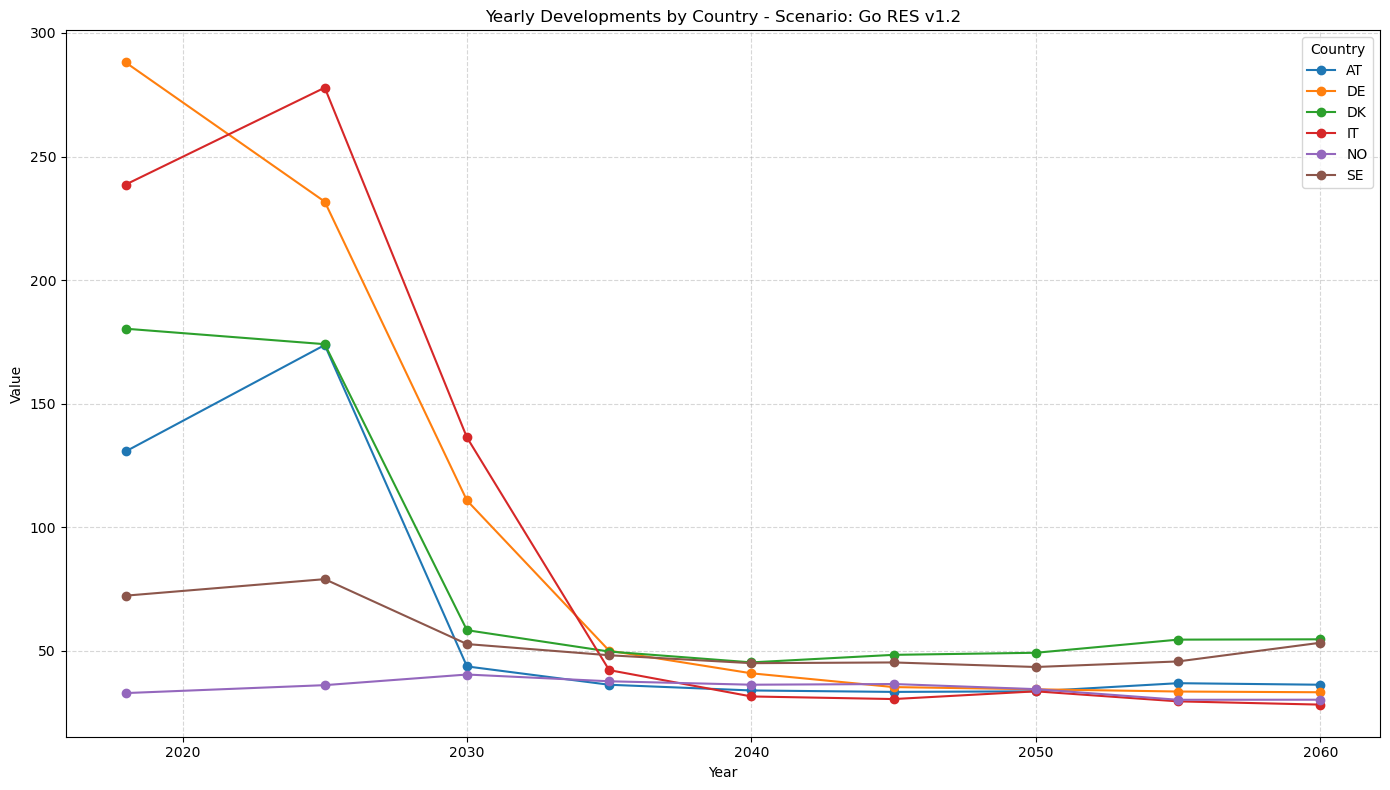

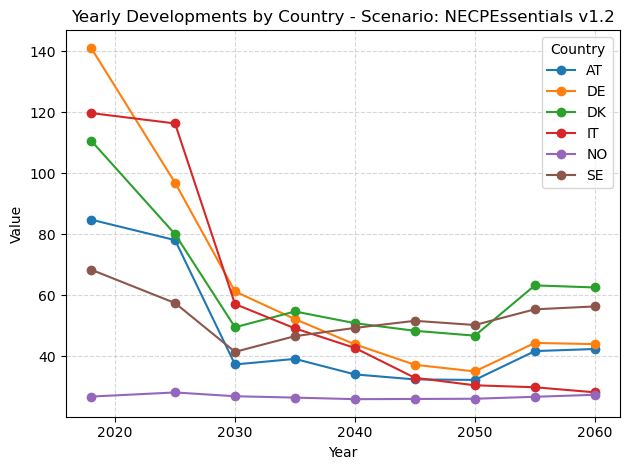

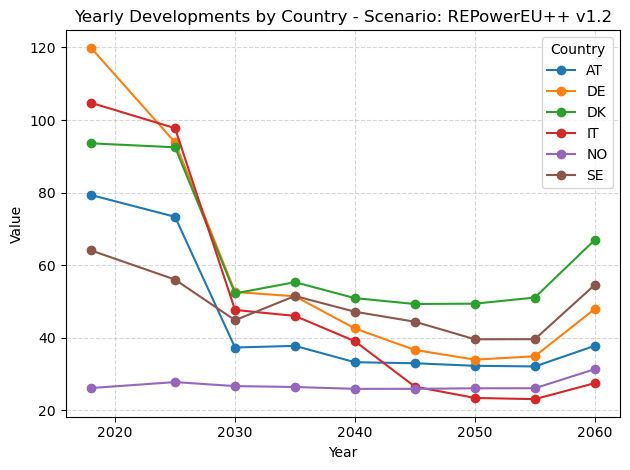

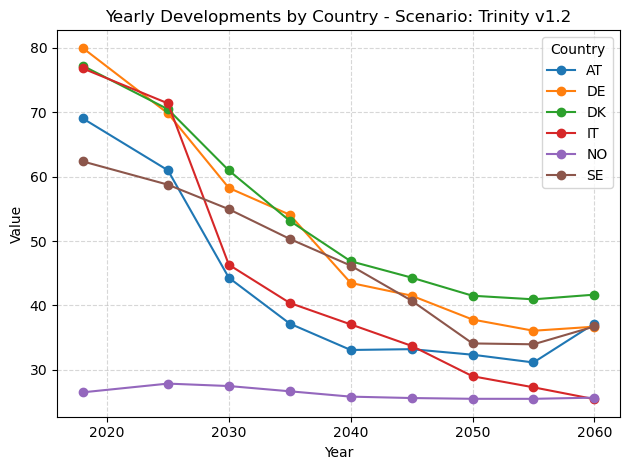

In [56]:
import matplotlib.pyplot as plt

scenarios = filtered_excel['Model Version'].unique()
countries = filtered_excel['Region'].unique()
years = sorted(filtered_excel['Year'].unique())

plt.figure(figsize=(14, 8))

for scenario in scenarios:
    for country in countries:
        df = filtered_excel[(filtered_excel['Model Version'] == scenario) & (filtered_excel['Region'] == country) & (filtered_excel['Unit'] == "Fuel Costs in EUR/MWh")]
        if not df.empty:
            df_sorted = df.sort_values('Year')
            plt.plot(df_sorted['Year'], df_sorted['Value '], marker='o', label=country)
    plt.title(f"Yearly Developments by Country - Scenario: {scenario}")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend(title="Country")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


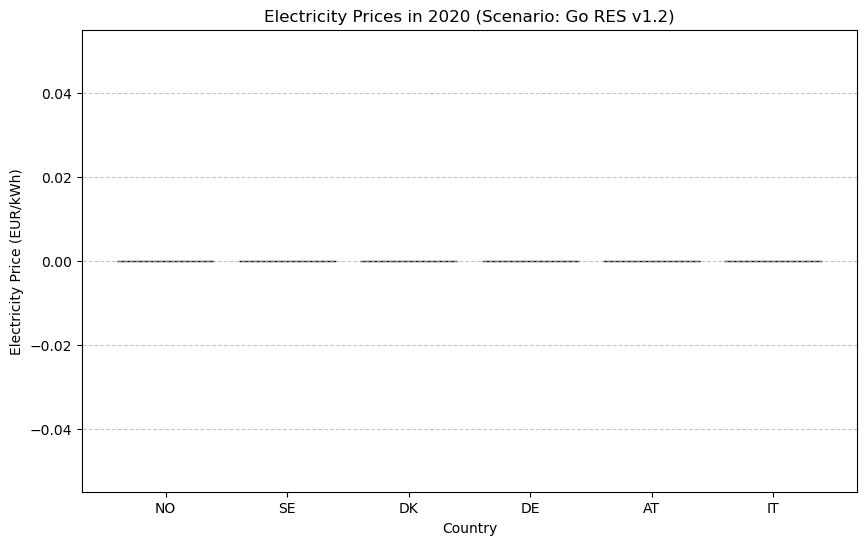

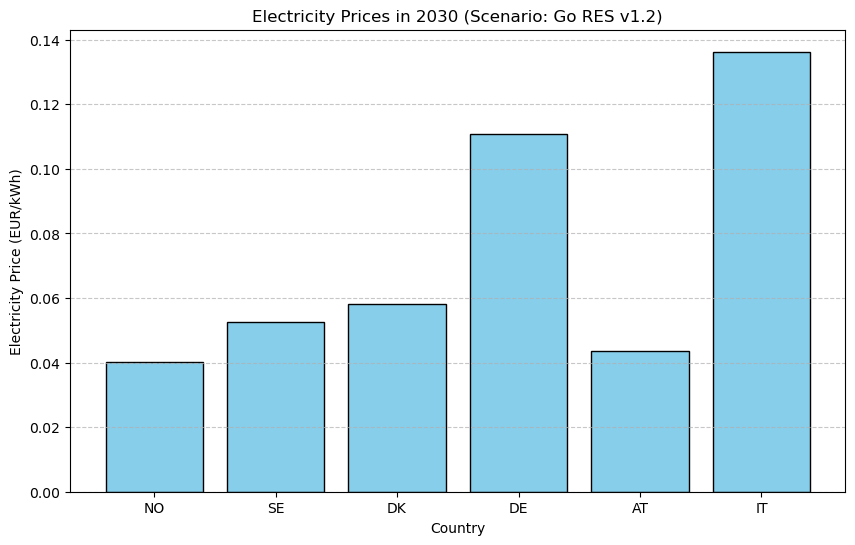

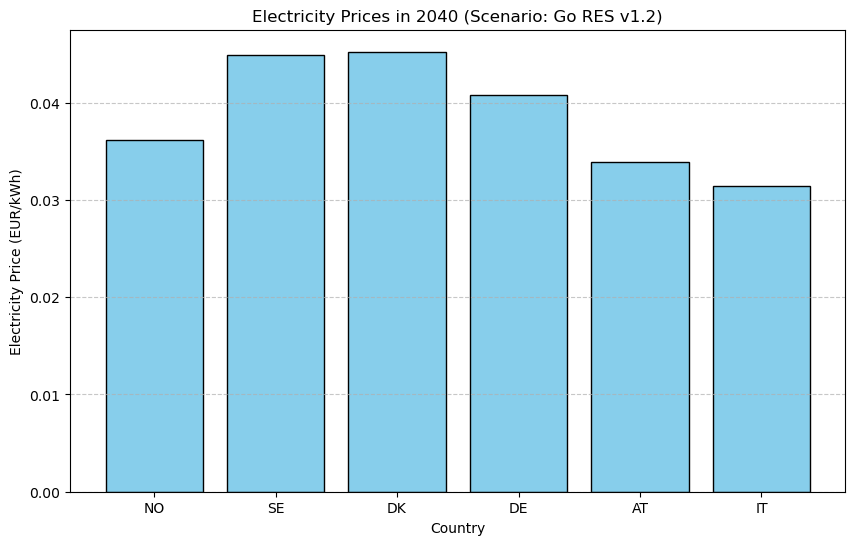

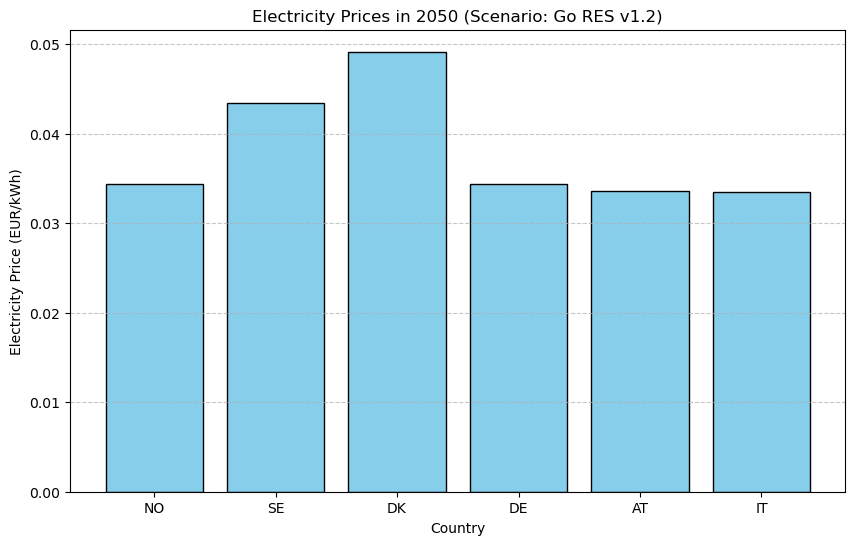

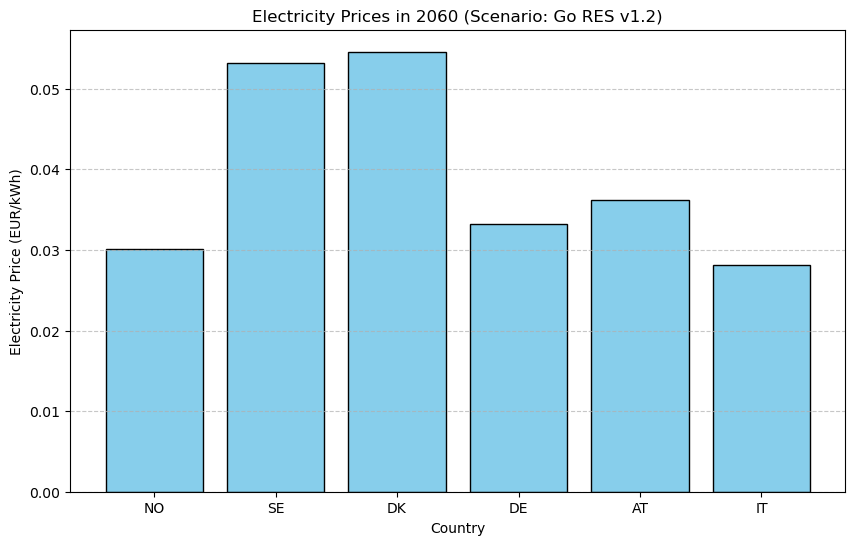

In [62]:
order = ["NO", "SE", "DK", "DE", "AT", "IT"]
import matplotlib.pyplot as plt

# Filter electricity prices for the selected scenario and years
selected_scenario = 'Go RES v1.2'
years_to_plot = [2020, 2030, 2040, 2050, 2060]

# Filter the data for the selected scenario and years
filtered_prices = elec_prices[
    (elec_prices['NUTS_region'].isin(order)) &
    (elec_prices['year'].isin(years_to_plot))
]

# Create a bar plot for each year
for year in years_to_plot:
    year_data = filtered_prices[filtered_prices['year'] == year]
    prices = [year_data[year_data['NUTS_region'] == country]['elec_price_EURperkWh'].values[0] if country in year_data['NUTS_region'].values else 0 for country in order]
    
    plt.figure(figsize=(10, 6))
    plt.bar(order, prices, color='skyblue', edgecolor='black')
    plt.title(f"Electricity Prices in {year} (Scenario: {selected_scenario})")
    plt.xlabel("Country")
    plt.ylabel("Electricity Price (EUR/kWh)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [57]:
# creating location dependent costs for fuel 

# Parameter to control whether electricity prices vary by location
# False: Use average electricity prices for all locations (uniform pricing)
# True: Use location-specific electricity prices based on NUTS_region

av_electricity_tax = filtered_conn_costs["CostElectricityT"].mean()

avg_elec_prices_per_year = elec_prices.groupby("year")["elec_price_EURperkWh"].mean().reset_index()
av_elec_price_dict = dict(zip([int(year) for year in avg_elec_prices_per_year["year"].to_list()], avg_elec_prices_per_year["elec_price_EURperkWh"].to_list()))
av_all_elec_prices = extrapolate_years(av_elec_price_dict, range(y_init, y_init + Y))
av_electricity_prices = [float(av_all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]

fc_id = 0
fuel_cost_list = []

for geo in geographic_elements:
    # Use the country attribute we added to geo elements
    country_code = geo["country"]
    
    # Calculate location-specific electricity prices
    extract_elec_prices = elec_prices[elec_prices['NUTS_region'] == country_code]
    elec_price_dict = dict(zip([int(item) for item in extract_elec_prices["year"].to_list()], extract_elec_prices["elec_price_EURperkWh"].to_list()))
    all_elec_prices = extrapolate_years(elec_price_dict, range(y_init, y_init + Y))
    electricity_prices = [float(all_elec_prices[y] + av_electricity_tax) for y in range(y_init, y_init + Y)]
    
    # Use electricity_prices_variable parameter to determine which prices to use
    if electricity_prices_variable:
        # Use location-specific prices
        cost_per_kWh = electricity_prices
    else:
        # Use uniform average prices for all locations
        cost_per_kWh = av_electricity_prices
    
    fuel_cost_list.append({
        "id": fc_id,
        "location": geo["id"],
        "fuel": "electricity",
        "cost_per_kWh": cost_per_kWh,
    })
    fc_id += 1
    
    fuel_cost_list.append({
        "id": fc_id,
        "location": geo["id"],
        "fuel": "diesel",
        "cost_per_kWh": [0.065] * Y,  # Assuming a constant diesel price for simplicity
    })
    fc_id += 1

pricing_mode = "location-specific" if electricity_prices_variable else "uniform (average)"
print(f"Created {len(fuel_cost_list)} fuel cost entries for {len(geographic_elements)} geo elements")
print(f"Electricity pricing mode: {pricing_mode}")

Created 1146 fuel cost entries for 573 geo elements
Electricity pricing mode: uniform (average)


In [58]:
fuel_list = [{
    "id": 0,
    "name": "electricity",
    "emission_factor": [0.0] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
},
{
    "id": 1,
    "name": "diesel",
    "emission_factor": [266] * Y,  # kg CO2e/kWh
    "cost_per_kWh": [0.0] * Y,  # EUR/kWh
    "cost_per_kW": [0.0] * Y,  # EUR/kW
    "fueling_infrastructure_om_costs": [0.0] * Y,  # EUR/kW/year
}]

Created 573 network cost entries for 573 geo elements


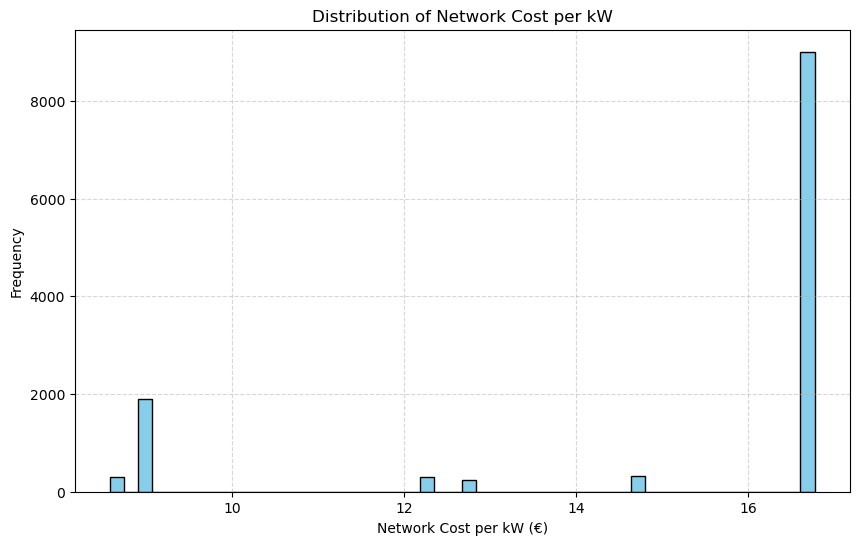

In [59]:
# geographically varying network costs
annually_charged_energy = filtered_conn_costs["ChargingEnergy"].mean()
av_network_cost = filtered_conn_costs["CostElectricityN"].mean() * annually_charged_energy / reference_cap  
network_cost_list = []
nc_id = 0
costs_by_country = {}

for geo in geographic_elements:
    # Use the country attribute we added to geo elements
    country_code = geo["country"]
    extract_df = filtered_conn_costs[filtered_conn_costs['Code'] == country_code]

    network_cost_value = extract_df["CostElectricityN"].values[0] * annually_charged_energy / reference_cap   # €/kW 
    
    if case in [1, 3]:
        network_cost_list.append({
            "id": nc_id,
            "name": geo["id"],
            "network_cost_per_kW": [float(network_cost_value)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    else:
        network_cost_list.append({
            "id": nc_id,
            "name": geo["id"],
            "network_cost_per_kW": [float(network_cost_value)] * Y,  # Assuming constant network cost per kW for simplicity
        })
    
    costs_by_country[country_code] = network_cost_value
    nc_id += 1

print(f"Created {len(network_cost_list)} network cost entries for {len(geographic_elements)} geo elements")

# Extract all network_cost_per_kW values into a flat list
network_cost_values = [cost for entry in network_cost_list for cost in entry["network_cost_per_kW"]]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(network_cost_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Network Cost per kW (€)')
plt.ylabel('Frequency')
plt.title('Distribution of Network Cost per kW')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [60]:
import yaml

data = {
    "TechVehicle": tech_vehicle_list,
    "GeographicElement": geographic_elements,
    "FinancialStatus": financial_status_list,
    "Vehicletype": vehicle_type_list,
    "Mode": mode_list,
    "Technology": [{
        "id": 0, 
        "name": "ICEV",	
        "fuel": "diesel",
    }, {
        "id": 1, 
        "name": "BEV",	
        "fuel": "electricity",
    }],
    "Speed": speed_list,
    "Regiontype": region_list,
    "InitialModeInfr": initialmodeinfr,
    "InitialFuelInfr": initialfuelinfr,
    "Odpair": odpair_list,
    "Path": path_list,
    "Fuel": fuel_list,
    "FuelCost": fuel_cost_list,
    "FuelingInfrTypes": charging_types_list,
    "InitialVehicleStock": initial_vehicle_stock,
    "InitialFuelingInfr": initialfuelinfr,
    "NetworkConnectionCosts": network_cost_list,
    "Product": [{"id": 0, "name": "freight"}],
    "Model": {"Y": Y, "pre_y": 25, "y_init": y_init, "gamma": 0.0001, "budget_penalty_plus": 10000, "budget_penalty_minus": 10000, "discount_rate": 0.05, "investment_period": 5, "budget_penalty_yearly_plus": 10000, "budget_penalty_yearly_minus": 10000, "pre_age_sell": False},
    "SpatialFlexibilityEdges": spatial_flex_range_list,
    "MandatoryBreaks": mandatory_breaks_list,

}

In [61]:
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
case_name = f"case_{case}_{timestamp}"
case_dir = f"input_data/{case_name}"
os.makedirs(case_dir, exist_ok=True)

print(f"Creating input data in: {case_dir}")

# Define all components
components = {
    "Model": {
        "Y": Y, "pre_y": prey_y, "y_init": y_init, "gamma": 0.0001,
        "budget_penalty_plus": 10000, "budget_penalty_minus": 10000,
        "discount_rate": 0.05, "investment_period": 5,
        "budget_penalty_yearly_plus": 10000000, "budget_penalty_yearly_minus": 10000000, "pre_age_sell": False
    },
    "TechVehicle": tech_vehicle_list,
    "GeographicElement": geographic_elements,
    "FinancialStatus": financial_status_list,
    "Vehicletype": vehicle_type_list,
    "Mode": mode_list,
    "Technology": technology_list,
    "Speed": speed_list,
    "Regiontype": region_list,
    "InitialModeInfr": initialmodeinfr,
    "InitialFuelInfr": initialfuelinfr,
    "Odpair": odpair_list,
    "Path": path_list,
    "Fuel": fuel_list,
    "FuelCost": fuel_cost_list,
    "FuelingInfrTypes": charging_types_list,
    "InitialVehicleStock": initial_vehicle_stock,
    "NetworkConnectionCosts": network_cost_list,
    "Product": [{"id": 0, "name": "freight"}],
    "SpatialFlexibilityEdges": spatial_flex_range_list,
    "MandatoryBreaks": mandatory_breaks_list,
}

# Save each component to a separate YAML file
import time
start_time = time.time()


import numpy as np

def convert_to_native_types(obj):
    """Convert NumPy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Apply conversion to ALL components before saving
print("Converting NumPy types to native Python types...")
for key in components:
    components[key] = convert_to_native_types(components[key])
for component_name, component_data in components.items():
    filepath = os.path.join(case_dir, f"{component_name}.yaml")
    with open(filepath, 'w') as f:
        yaml.dump(component_data, f, default_flow_style=False)
    print(f"  Saved {component_name}.yaml")

elapsed = time.time() - start_time
print(f"\nTotal time: {elapsed:.2f} seconds")
print(f"Case directory: {case_dir}")

Creating input data in: input_data/case_1_20251015_150712
Converting NumPy types to native Python types...
  Saved Model.yaml
  Saved TechVehicle.yaml
  Saved GeographicElement.yaml
  Saved FinancialStatus.yaml
  Saved Vehicletype.yaml
  Saved Mode.yaml
  Saved Technology.yaml
  Saved Speed.yaml
  Saved Regiontype.yaml
  Saved InitialModeInfr.yaml
  Saved InitialFuelInfr.yaml
  Saved Odpair.yaml
  Saved Path.yaml
  Saved Fuel.yaml
  Saved FuelCost.yaml
  Saved FuelingInfrTypes.yaml
  Saved InitialVehicleStock.yaml
  Saved NetworkConnectionCosts.yaml
  Saved Product.yaml
  Saved SpatialFlexibilityEdges.yaml
  Saved MandatoryBreaks.yaml

Total time: 4.43 seconds
Case directory: input_data/case_1_20251015_150712
